In [1]:
from __future__ import print_function, division
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 150}

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import ipyparallel as ipp
client = ipp.Client()
client[:].use_dill()
lbview = client.load_balanced_view()

In [3]:
import numpy as np
with client[:].sync_imports():
    import scipy
    import scipy.stats
client[:].push(dict(np=np))
import qinfer as qi
from talk_figures import SampleTimeHeuristic, UnknownT2Model
from functools import partial

importing scipy on engine(s)
importing scipy.stats on engine(s)


In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot-rq')

In [5]:
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.facecolor'] = '#888888'

In [6]:
nyquist_heuristic = partial(SampleTimeHeuristic, t_func=lambda k: 2750 * k / 2000)
exp_sparse_heuristic = partial(SampleTimeHeuristic, t_func=lambda k: 1.0049 ** k)

In [11]:
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', [
    '#D55E00', 
    '#00BC84'
])

2751375.0
3610726.14114


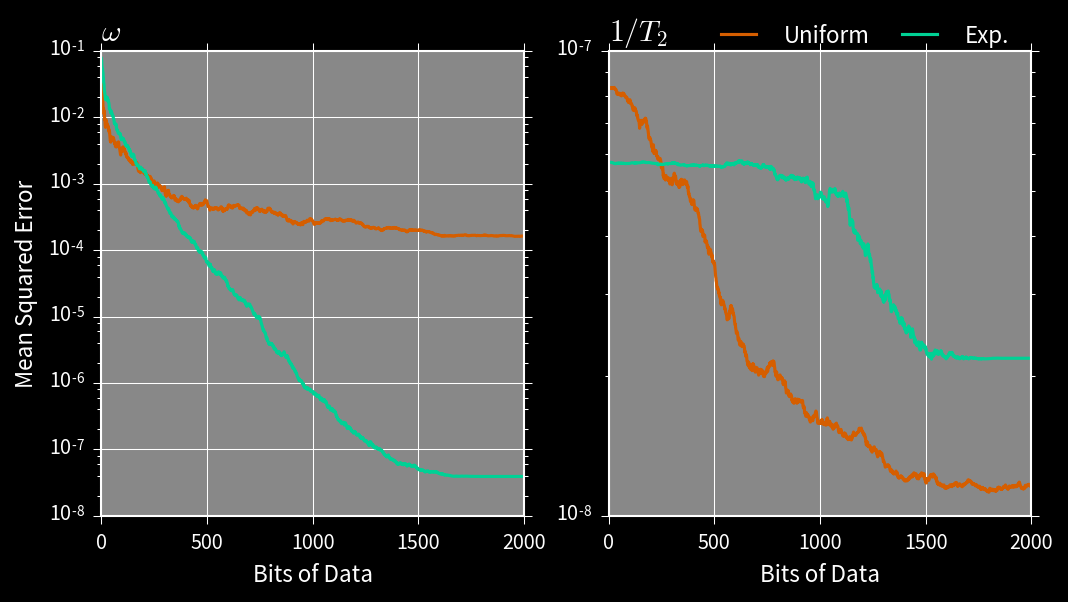

In [17]:
fig, subplots = plt.subplots(ncols=2, figsize=(8, 4))

for heuristic, label in (
        (nyquist_heuristic, r'Uniform'),
        (exp_sparse_heuristic, r'Exp.')
    ):
    perf = qi.perf_test_multiple(100,
        UnknownT2Model(), 10000,
        qi.ProductDistribution(
            qi.UniformDistribution([0, 1]),
            qi.NormalDistribution(0.001, 0.00025 ** 2)
        ),
        2000, heuristic,
        progressbar=qi.IPythonProgressBar,
        apply=lbview.apply,
        extra_updater_args={
            'resampler': qi.LiuWestResampler(a=0.9)
        }
    )
    print(perf['experiment'][0].sum())
    risk_by_param = ((perf['est'] - perf['true']) ** 2).mean(axis=0).T
    
    for subplot, risk, param_name in zip(subplots, risk_by_param, map('${}$'.format, UnknownT2Model().modelparam_names)):
        subplot.semilogy(risk, label=label)
        subplot.set_title(param_name, loc='left')
        subplot.set_xlabel('Bits of Data')
        
subplots[0].set_ylabel('Mean Squared Error')
        
plt.legend(ncol=3, bbox_to_anchor=(1, 1.105), columnspacing=1.0)
plt.savefig('figures/unknown-t2.png', dpi=250, facecolor='k', frameon=False)

### QBS Data ###

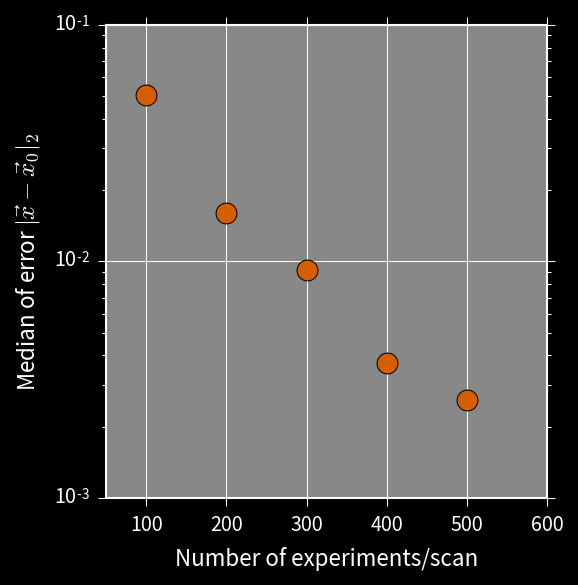

In [22]:
x = [100, 200, 300, 400, 500]
y = [0.0506, 0.0160, 0.0092, 0.0037, 0.0026]

fig = plt.figure(figsize=(4, 4))
plt.semilogy(x, y, 'o', markersize=10);
plt.xlim((50, 600))
plt.xlabel('Number of experiments/scan')
plt.ylabel(r'Median of error $|\vec{x}-\vec{x}_{0}|_2$')
fig.tight_layout()

plt.savefig('./figures/qbs-error-per-scan.png', dpi=500, facecolor='k', frameon=False)

### Impovrishment ###

In [24]:
particles_good = np.random.randn(1200, 2)

particles_bad = np.random.uniform(-4, 4, (400, 2))
wts_bad = np.product(scipy.stats.norm.pdf(particles_bad), axis=1)
wts_bad /= wts_bad.sum()

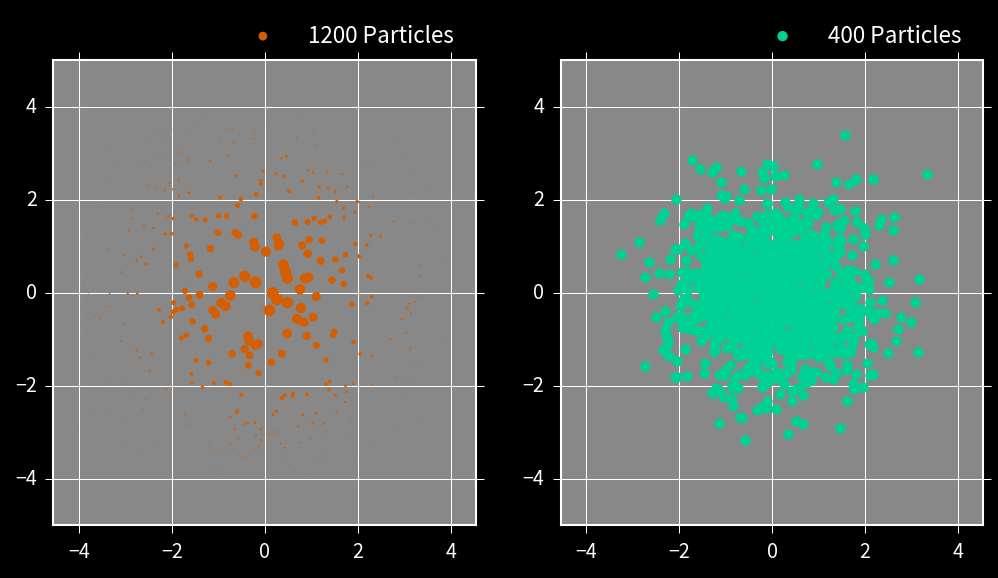

In [32]:
try: style_cycle = plt.rcParams['axes.prop_cycle']()
except:
    from cycler import cycler
    style_cycle = iter(cycler('color', plt.rcParams['axes.color_cycle']))
    
plt.figure(figsize=(8, 4))
ax = plt.subplot(1, 2, 1)
plt.scatter(particles_bad[:, 0], particles_bad[:, 1], s=1200 * wts_bad, **style_cycle.next())
plt.legend(['1200 Particles'],bbox_to_anchor=(1, 1.125), scatterpoints=1)
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.scatter(particles_good[:, 0], particles_good[:, 1], **style_cycle.next())
plt.legend(['400 Particles'],bbox_to_anchor=(1, 1.125), scatterpoints=1)
plt.gca().set_aspect('equal')

plt.savefig('figures/impovrishment.png', format='png', dpi=300, frameon=False, facecolor="black")

### Example: Rabi/Ramsey ###

In [33]:
w = 70.3
w_max = 100.0

ts = np.pi * (1 + np.arange(100)) / (2 * w_max)


ideal_signal = np.sin(w * ts / 2) ** 2

In [34]:
n_shots = 100
counts = np.random.binomial(n=n_shots, p=ideal_signal)

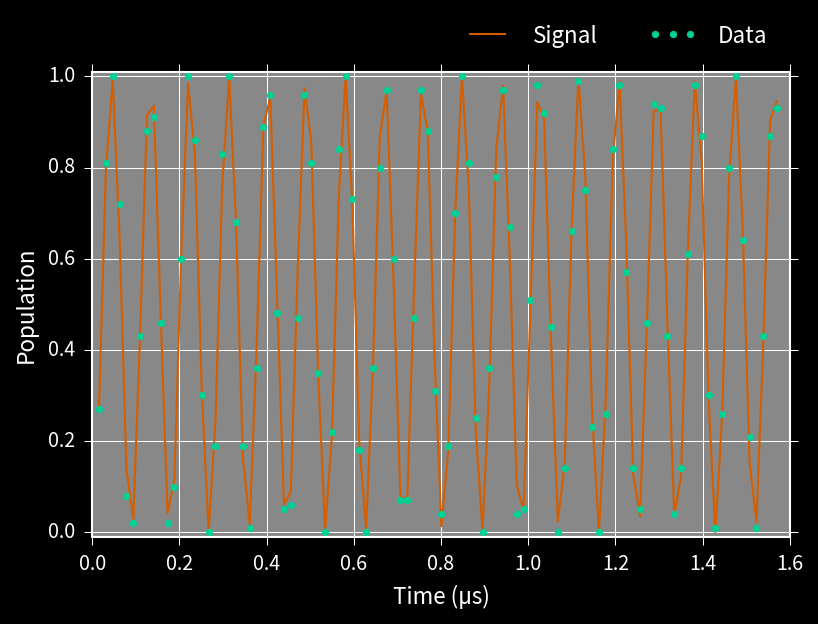

In [35]:
plt.plot(ts, ideal_signal, label='Signal', lw=1)
plt.plot(ts, counts / n_shots, '.', label='Data')
plt.xlabel(u'Time (µs)')
plt.ylabel(r'Population')
plt.ylim(-0.01, 1.01)
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15), numpoints=3)
plt.savefig('figures/rabi-example-signal.png', format='png', dpi=300, frameon=False, facecolor="black")

In [36]:
ideal_spectrum = np.abs(np.fft.fftshift(np.fft.fft(ideal_signal - ideal_signal.mean())))**2
spectrum = np.abs(np.fft.fftshift(np.fft.fft((counts - counts.mean()) / n_shots)))**2
ft_freq = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(n=len(counts), d=ts[1] - ts[0]))

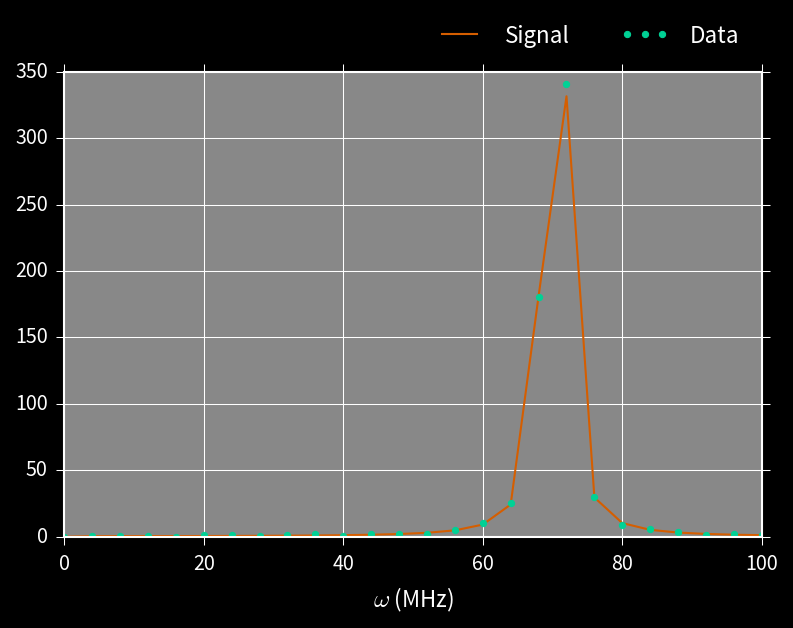

In [37]:
plt.plot(ft_freq, ideal_spectrum, lw=1, label='Signal')
plt.plot(ft_freq, spectrum, '.', label='Data')
ylim = plt.ylim()
# plt.vlines(w, *ylim)
plt.xlim(xmin=0, xmax=100)
# plt.ylim(*ylim)
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15), numpoints=3)
plt.xlabel('$\omega$ (MHz)')
plt.savefig('figures/rabi-example-spectrum.png', format='png', dpi=300, frameon=False, facecolor="black")